In [0]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Obtain Data

#Load NYC taxi data
df_taxi_train = pd.read_csv('/content/gdrive/My Drive/BigDataProj/NYTaxi train.csv')
df_taxi_test = pd.read_csv('/content/gdrive/My Drive/BigDataProj/NYTaxi test.csv')

#Load Collisions data
df_collisions = pd.read_csv('/content/gdrive/My Drive/BigDataProj/NYPD_Motor_Vehicle_Collisions.csv', index_col='UNIQUE KEY', 
                         parse_dates={'DATETIME':["DATE","TIME"]})

#Load OSRM data
df_fr_test = pd.read_csv('/content/gdrive/My Drive/BigDataProj/fastest_routes_test.csv')
df_fr_train_p1 = pd.read_csv('/content/gdrive/My Drive/BigDataProj/fastest_routes_train_part_1.csv')
df_fr_train_p2 = pd.read_csv('/content/gdrive/My Drive/BigDataProj/fastest_routes_train_part_2.csv')



In [0]:
#clean OSRM data

#Create a subset of OSRM data with id, total_distance and number of steps

df_fr_train_p1_subset = df_fr_train_p1[['id','total_distance','number_of_steps']]

df_fr_train_p2_subset = df_fr_train_p2[['id','total_distance','number_of_steps']]

df_fr_test_subset = df_fr_test[['id','total_distance','number_of_steps']]


In [0]:
#Combine the two OSRM dataset
df_fr_train =  df_fr_train_p1_subset.append(df_fr_train_p2_subset)

In [8]:
#check data
df_fr_train_p1.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [9]:
#EDA on the training dataset
df_taxi_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [10]:
#Merge Taxi Training data and OSRM data 
df_taxi_osrm_merged = pd.merge(df_taxi_train, df_fr_train, how='left', on='id')

df_taxi_osrm_merged.info()

df_taxi_osrm_merged.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
total_distance        1458643 non-null float64
number_of_steps       1458643 non-null float64
dtypes: float64(6), int64(3), object(4)
memory usage: 155.8+ MB


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,total_distance,number_of_steps
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458643e+06,1.458643e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,4.626383e+03,7.547126e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,5.303878e+03,4.432504e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,2.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.666100e+03,5.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,2.755100e+03,6.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.113800e+03,9.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,9.420420e+04,4.600000e+01


In [11]:
#Merge Taxi Test data and OSRM Test data 
df_taxi_osrm_test_merged = pd.merge(df_taxi_test, df_fr_test, how='left', on='id')

df_taxi_osrm_test_merged.info()

df_taxi_osrm_test_merged.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625134 entries, 0 to 625133
Data columns (total 20 columns):
id                      625134 non-null object
vendor_id               625134 non-null int64
pickup_datetime         625134 non-null object
passenger_count         625134 non-null int64
pickup_longitude        625134 non-null float64
pickup_latitude         625134 non-null float64
dropoff_longitude       625134 non-null float64
dropoff_latitude        625134 non-null float64
store_and_fwd_flag      625134 non-null object
starting_street         625134 non-null object
end_street              625134 non-null object
total_distance          625134 non-null float64
total_travel_time       625134 non-null float64
number_of_steps         625134 non-null int64
street_for_each_step    625134 non-null object
distance_per_step       625134 non-null object
travel_time_per_step    625134 non-null object
step_maneuvers          625134 non-null object
step_direction          625134 non-null 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_distance,total_travel_time,number_of_steps
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816,4616.899919,388.926100,7.545392
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824,5279.273407,313.726758,4.435818
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322,0.000000,0.000000,2.000000
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000,1665.400000,181.500000,5.000000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543,2754.650000,289.300000,6.000000
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852,5116.300000,490.600000,9.000000
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597,91521.700000,4578.100000,50.000000


In [0]:
#Create a subset where trip duration in greater than 100 and less than 10000 to train
df_taxi_osrm_merged =df_taxi_osrm_merged[(df_taxi_osrm_merged.trip_duration < 10000) & (df_taxi_osrm_merged.trip_duration > 100)]

#drop id and store_and_fwd_flag
df_taxi_osrm_merged.drop(["id"], axis=1, inplace=True)
df_taxi_osrm_merged.drop(["store_and_fwd_flag"], axis=1, inplace=True)



In [0]:
#convert pickup_datetime to date datatype in training data
df_taxi_osrm_merged["pickup_datetime"] = pd.to_datetime(df_taxi_osrm_merged.pickup_datetime)

#convert pickup_datetime to date datatype in test data
df_taxi_osrm_test_merged["pickup_datetime"] = pd.to_datetime(df_taxi_osrm_test_merged.pickup_datetime)

#Add date column to train dataset
#df_taxi_osrm_merged['DATE'] = df_taxi_osrm_merged['pickup_datetime'].dt.date
#df_taxi_osrm_merged.info()

#Add date column to test dataset
#df_taxi_osrm_test_merged['DATE'] = df_taxi_osrm_test_merged['pickup_datetime'].dt.date
#df_taxi_osrm_test_merged.info()

In [14]:
df_taxi_osrm_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625134 entries, 0 to 625133
Data columns (total 20 columns):
id                      625134 non-null object
vendor_id               625134 non-null int64
pickup_datetime         625134 non-null datetime64[ns]
passenger_count         625134 non-null int64
pickup_longitude        625134 non-null float64
pickup_latitude         625134 non-null float64
dropoff_longitude       625134 non-null float64
dropoff_latitude        625134 non-null float64
store_and_fwd_flag      625134 non-null object
starting_street         625134 non-null object
end_street              625134 non-null object
total_distance          625134 non-null float64
total_travel_time       625134 non-null float64
number_of_steps         625134 non-null int64
street_for_each_step    625134 non-null object
distance_per_step       625134 non-null object
travel_time_per_step    625134 non-null object
step_maneuvers          625134 non-null object
step_direction          625134 n

In [0]:
#Add Temporal columns to both test and training data
df_taxi_osrm_merged['week'] = df_taxi_osrm_merged.pickup_datetime.dt.week
df_taxi_osrm_merged['weekday'] = df_taxi_osrm_merged.pickup_datetime.dt.weekday
df_taxi_osrm_merged['hour'] = df_taxi_osrm_merged.pickup_datetime.dt.hour
df_taxi_osrm_merged.drop(['pickup_datetime'], axis=1, inplace=True)


In [0]:
#Add Temporal columns to both test and training data
df_taxi_osrm_test_merged['week'] = df_taxi_osrm_test_merged.pickup_datetime.dt.week
df_taxi_osrm_test_merged['weekday'] = df_taxi_osrm_test_merged.pickup_datetime.dt.weekday
df_taxi_osrm_test_merged['hour'] = df_taxi_osrm_test_merged.pickup_datetime.dt.hour
df_taxi_osrm_test_merged.drop(['pickup_datetime'], axis=1, inplace=True)


In [0]:
df_taxi_osrm_merged = df_taxi_osrm_merged.rename(index=str, columns={"pickup_latitude": "LATITUDE", "pickup_longitude": "LONGITUDE"})

In [18]:
# Get only the attributes which influence trip duration

df_taxi_attrib = df_taxi_osrm_merged[['total_distance','number_of_steps','week','weekday','hour','trip_duration','LATITUDE','LONGITUDE','dropoff_longitude','dropoff_latitude']]

#Total distance to be greater than zero

df_taxi_attrib = df_taxi_attrib[df_taxi_attrib['total_distance'] > 0]

df_taxi_attrib.describe()

corr = df_taxi_attrib.corr()

corr.style.background_gradient().set_precision(2)




,total_distance,number_of_steps,week,weekday,hour,trip_duration,LATITUDE,LONGITUDE,dropoff_longitude,dropoff_latitude
total_distance,1,0.79,0.023,0.0072,-0.019,0.77,-0.29,0.54,0.33,-0.16
number_of_steps,0.79,1,0.018,0.018,-0.022,0.67,-0.23,0.35,0.27,-0.19
week,0.023,0.018,1,0.038,-0.017,0.039,-0.0065,0.011,0.0099,-0.0039
weekday,0.0072,0.018,0.038,1,-0.084,-0.034,-0.032,-0.031,-0.0019,-0.023
hour,-0.019,-0.022,-0.017,-0.084,1,0.027,0.012,0.019,-0.043,0.015
trip_duration,0.77,0.67,0.039,-0.034,0.027,1,-0.22,0.37,0.22,-0.18
LATITUDE,-0.29,-0.23,-0.0065,-0.032,0.012,-0.22,1,-0.13,0.069,0.4
LONGITUDE,0.54,0.35,0.011,-0.031,0.019,0.37,-0.13,1,0.24,0.054
dropoff_longitude,0.33,0.27,0.0099,-0.0019,-0.043,0.22,0.069,0.24,1,0.11
dropoff_latitude,-0.16,-0.19,-0.0039,-0.023,0.015,-0.18,0.4,0.054,0.11,1


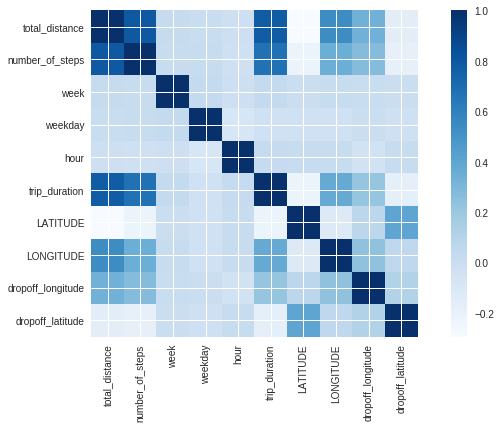

In [19]:
# plot correlation matrix
plt.rcParams['figure.figsize'] = (12, 6)
plt.imshow(corr, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(corr.columns))]
plt.xticks(tick_marks, corr.columns, rotation='vertical')
plt.yticks(tick_marks, corr.columns)
plt.show()

In [20]:
#Model Creation - to predict trip duration
y = df_taxi_attrib["trip_duration"]
df_taxi_attrib.drop(["trip_duration"], axis=1, inplace=True)
X = df_taxi_attrib 
X.shape, y.shape

((1433180, 9), (1433180,))

In [21]:
#Split the training data - 80% for training and 20% for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1146544, 9), (1146544,), (286636, 9), (286636,))

In [0]:
#linear regression
import sklearn.linear_model as lm

model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import r2_score


In [24]:
r2_score(y_test, y_val_pred)

0.6165338153130862

In [25]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

print("Validation Error: ", mae(y_test, y_val_pred))

Validation Error:  273.53435765553064


In [28]:
#Run Random Forest modle with n_estimators = 20 and max_depth = 80

m1 = RandomForestRegressor(n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
m1.fit(X_train, y_train)
m1.score(X_valid, y_valid)

0.7981658716805347

In [29]:

#Run Random Forest modle with n_estimators = 100 and max_depth = 60

m1 = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=60, bootstrap=True)
m1.fit(X_train, y_train)
m1.score(X_valid, y_valid)

0.8037941728360292

In [0]:
#Predict the test data using the model
y_pred=m1.predict(X_valid)

In [0]:
feature_imp = pd.Series(m1.feature_importances_,attribs_1).sort_values(ascending=False)

In [0]:
#Determine feature importance score of the features used in the model

attribs_1 = ['total_distance','number_of_steps','LATITUDE','LONGITUDE','hour','week','weekday','dropoff_longitude','dropoff_latitude']

feature_imp = pd.Series(m1.feature_importances_,attribs_1).sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


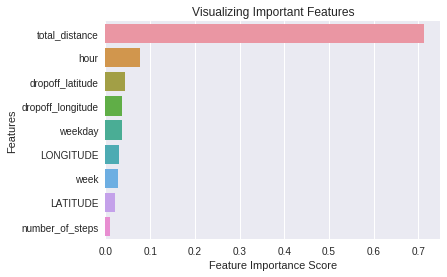

In [36]:

feature_imp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()